<a href="https://colab.research.google.com/github/GGpark1/User-Log-data-analytics/blob/main/e_commerce_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Module import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#pd.options.display.float_format = "{:,.2f}".format
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import warnings
warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv('/content/drive/MyDrive/CP2/2019-Oct.csv')

In [4]:
#df['event_time'] = pd.to_datetime(df['event_time']).dt.tz_convert('Asia/Tehran')

df['event_time'] = pd.to_datetime(df['event_time']).dt.tz_convert(None)

TypeError: ignored

In [5]:
# price가 0인 log 데이터의 비율
# 삭제해도 무방할 비율처럼 보임

df.loc[df['price'] == 0].shape[0] / df.shape[0]

0.0016177856203304294

In [6]:
# category와 brand 모두 null인 데이터의 비율 
# 다소 크지만, 해당 데이터에서 파악할 수 있는 정보가 적으므로 삭제함

df.loc[df['category_code'].isnull() & df['brand'].isnull()].shape[0] / df.shape[0]

0.08821333407964482

In [7]:
# category와 brand 모두 null인 데이터 drop

df = df.loc[~(df['category_code'].isnull() & df['brand'].isnull())]

In [8]:
# price가 0인 데이터 drop
df = df.loc[~(df['price'] == 0)]

## Basic Preprocessing

In [9]:
# 시간 정보 삭제
# 요일 별 방문자 파악

daily_summary_table=df.groupby(by=[df['event_time'].dt.normalize()]).agg(
    Number_of_daily_visits=('user_session', lambda x: x.nunique()),
    Number_of_daily_visitors=('user_id', lambda x: x.nunique()))

## EDA

In [10]:
# 일자 별 방문 수
# 일자 별 방문자 수

daily_summary_table.head()

,Number_of_daily_visits,Number_of_daily_visitors
event_time,,
2019-10-01,254214,181404
2019-10-02,246700,176210
2019-10-03,229089,163367
2019-10-04,288557,202227
2019-10-05,264814,187681


In [11]:
# 일자 별 판매량
# 일자 별 판매액

sales = df.loc[df['event_type'] == 'purchase'].groupby(by=[df['event_time'].dt.normalize()]).agg(
    Number_of_daily_sales=('event_type', 'count'),
    Total_daily_sales=('price', 'sum')).reset_index()

sales.head()


,event_time,Number_of_daily_sales,Total_daily_sales
0,2019-10-01,18260,6120577.96
1,2019-10-02,18375,6048022.63
2,2019-10-03,18236,6065535.00
3,2019-10-04,25925,8470555.41
4,2019-10-05,22363,7192074.35


In [12]:
carts = df.loc[df['event_type'] == 'cart'].groupby(by=[df['event_time'].dt.normalize()]).agg(
    Number_of_daily_carts=('event_type', 'count')).reset_index()

carts.head()

,event_time,Number_of_daily_carts
0,2019-10-01,16615
1,2019-10-02,17173
2,2019-10-03,19257
3,2019-10-04,43623
4,2019-10-05,35325


In [13]:
daily_summary_table=pd.merge(left=daily_summary_table,
                          right=sales,
                          left_on=['event_time'],
                          right_on=['event_time'],
                          how='left')

In [14]:
daily_summary_table=pd.merge(left=daily_summary_table,
                          right=carts,
                          left_on=['event_time'],
                          right_on=['event_time'],
                          how='left')

In [15]:
daily_summary_table.head()

,event_time,Number_of_daily_visits,Number_of_daily_visitors,Number_of_daily_sales,Total_daily_sales,Number_of_daily_carts
0,2019-10-01,254214,181404,18260,6120577.96,16615
1,2019-10-02,246700,176210,18375,6048022.63,17173
2,2019-10-03,229089,163367,18236,6065535.00,19257
3,2019-10-04,288557,202227,25925,8470555.41,43623
4,2019-10-05,264814,187681,22363,7192074.35,35325


In [16]:
# 피쳐 순서 조정

daily_summary_table = daily_summary_table[['event_time', 'Number_of_daily_visits', 'Number_of_daily_visitors', 'Number_of_daily_carts', 'Number_of_daily_sales', 'Total_daily_sales']]

In [17]:
# 전환율 테이블 구성

conversion_table = pd.DataFrame({'event_time' : daily_summary_table['event_time']})

conversion_table['Visit-Cart-conversion'] = daily_summary_table['Number_of_daily_carts'] / daily_summary_table['Number_of_daily_visits']
conversion_table['Visit-Sale-conversion'] = daily_summary_table['Number_of_daily_sales'] / daily_summary_table['Number_of_daily_visits']
conversion_table['Cart-Sale-conversion'] = daily_summary_table['Number_of_daily_sales'] / daily_summary_table['Number_of_daily_carts']

In [18]:
conversion_table.head()

,event_time,Visit-Cart-conversion,Visit-Sale-conversion,Cart-Sale-conversion
0,2019-10-01,0.065358,0.071829,1.099007
1,2019-10-02,0.069611,0.074483,1.069994
2,2019-10-03,0.084059,0.079602,0.946980
3,2019-10-04,0.151176,0.089844,0.594297
4,2019-10-05,0.133396,0.084448,0.633064


### 방문 세션
- 일자별 방문 세션
  - 8~25일의 방문 세션이 평균보다 높음
- 요일별 방문 세션
  - 금요일에 방문 세션이 평균적으로 가장 많음
  - 목요일에 방문 세션이 평균적으로 가장 적음
- 고유 방문자 수와 방문 세션의 패턴이 일치함

In [19]:
print('Daily Visits Statistics')
print('-'*50)
print(daily_summary_table['Number_of_daily_visits'].describe())
print('-'*50)
print('Visit Statistics by Dates')
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name()).Number_of_daily_visits.describe())

Daily Visits Statistics
--------------------------------------------------
count        31.000000
mean     284750.516129
std       24692.622364
min      229089.000000
25%      265202.500000
50%      288416.000000
75%      303691.000000
max      323844.000000
Name: Number_of_daily_visits, dtype: float64
--------------------------------------------------
Visit Statistics by Dates
            count       mean           std       min        25%       50%  \
event_time                                                                  
Friday        4.0  305888.50  14018.984473  288557.0  297518.00  308345.5   
Monday        4.0  278990.00  25761.076414  249932.0  261676.25  280039.0   
Saturday      4.0  284032.75  17973.398814  264814.0  272493.25  282694.5   
Sunday        4.0  294600.25  31169.267945  260532.0  272097.00  297012.5   
Thursday      5.0  268620.40  23307.832166  229089.0  267514.00  279038.0   
Tuesday       5.0  285849.60  27677.900450  254214.0  261459.00  291776.0   
Wed

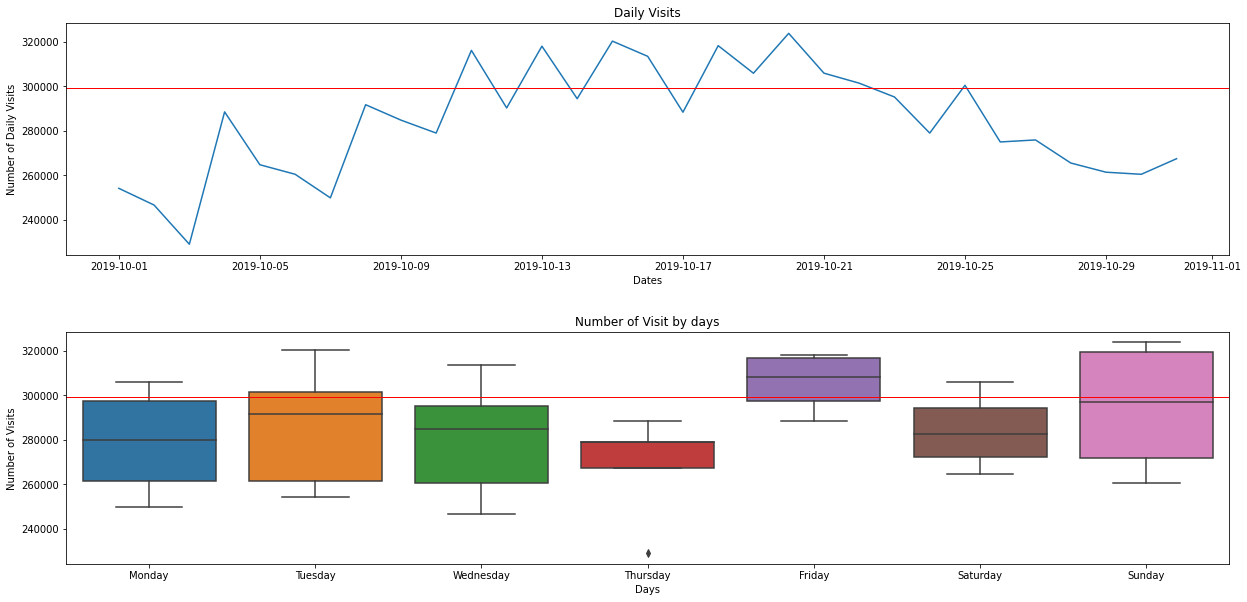

In [20]:
# 일자별 방문 세션

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Number_of_daily_visits',
              data=daily_summary_table,
             ax=ax1)
plt.axhline(y=299510, color='r', linewidth=1)
plt.title('Daily Visits')
plt.ylabel('Number of Daily Visits')
plt.xlabel('Dates')

# 요일별 방문 세션

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=daily_summary_table['Number_of_daily_visits'],
            ax=ax2)
plt.axhline(y=299510, color='r', linewidth=1)
plt.title('Number of Visit by days')
plt.ylabel('Number of Visits')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

### 판매량
- 일자별 판매량
  - 2~3일 판매량이 높음 : 해당 요일에 어떤 물건이 많이 팔리는지 확인 필요
  - 10일~19일 판매량 높음 : 해당 요일에 어떤 물건이 많이 팔리는지 확인 필요
- 요일별 판매량
  - 금, 일의 판매량이 높음
  - 화, 목의 판매량이 낮음
  - 요일별로 어떤 물건이 많이 팔리는지 확인 필요

In [21]:
print('Daily Sales Statistics')
print('-'*50)
print(daily_summary_table['Number_of_daily_sales'].describe())
print('-'*50)
print('Sales Statistics by Dates')
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name()).Number_of_daily_sales.describe())

Daily Sales Statistics
--------------------------------------------------
count       31.000000
mean     22724.548387
std       2974.412725
min      18236.000000
25%      20485.500000
50%      22591.000000
75%      24398.000000
max      29919.000000
Name: Number_of_daily_sales, dtype: float64
--------------------------------------------------
Sales Statistics by Dates
            count      mean          std      min      25%      50%       75%  \
event_time                                                                      
Friday        4.0  24441.50  1377.741509  22591.0  24092.5  24625.0  24974.00   
Monday        4.0  22808.75  3419.956956  19927.0  20143.0  22085.0  24750.75   
Saturday      4.0  22811.75  1055.521159  21551.0  22160.0  22908.5  23560.25   
Sunday        4.0  23742.25  2932.846214  21048.0  21928.5  23077.0  24890.75   
Thursday      5.0  21547.80  3501.747878  18236.0  18964.0  20756.0  22840.00   
Tuesday       5.0  21721.20  2996.335045  18260.0  19256.0  21

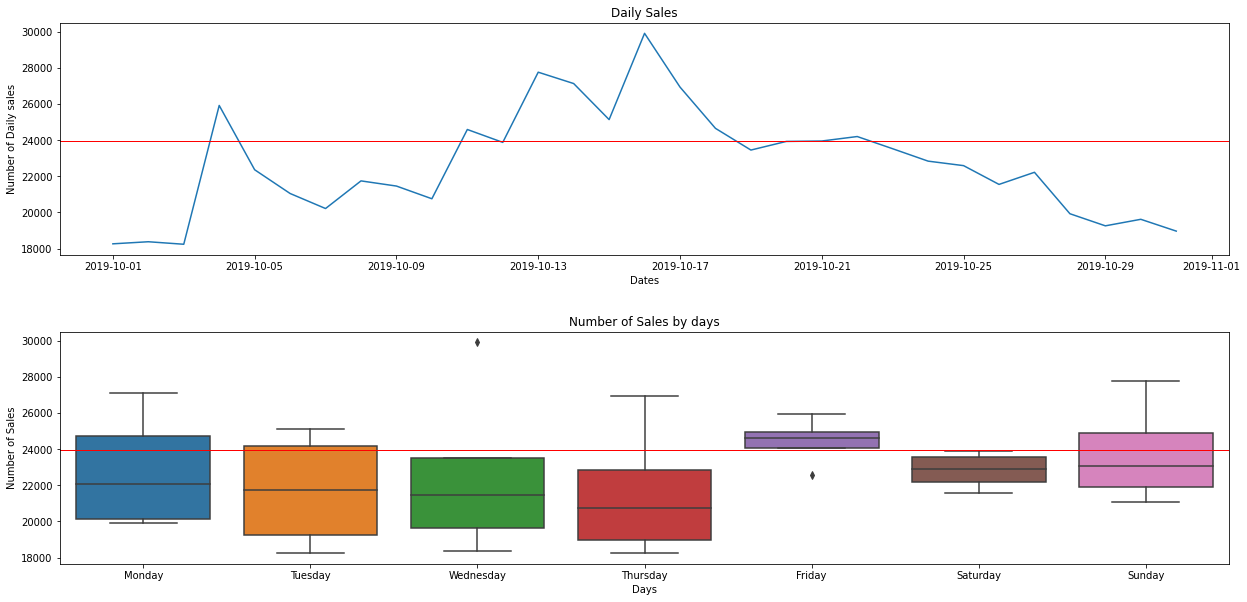

In [22]:
# 일자별 판매량

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Number_of_daily_sales',
              data=daily_summary_table,
             ax=ax1)
plt.axhline(y=23962, color='r', linewidth=1)
plt.title('Daily Sales')
plt.ylabel('Number of Daily sales')
plt.xlabel('Dates')

# 요일별 판매량

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=daily_summary_table['Number_of_daily_sales'],
            ax=ax2)
plt.axhline(y=23962, color='r', linewidth=1)
plt.title('Number of Sales by days')
plt.ylabel('Number of Sales')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

In [23]:
conversion_table.head()

,event_time,Visit-Cart-conversion,Visit-Sale-conversion,Cart-Sale-conversion
0,2019-10-01,0.065358,0.071829,1.099007
1,2019-10-02,0.069611,0.074483,1.069994
2,2019-10-03,0.084059,0.079602,0.946980
3,2019-10-04,0.151176,0.089844,0.594297
4,2019-10-05,0.133396,0.084448,0.633064


## Conversion 지표 정의

- Visit-Cart Conversion 


### Visit-Cart Conversion
- 방문 세션과 패턴이 대체로 일치함
- 주말의 Visit-Cart Conversion이 평일보다 평균적으로 높음
- Visit-Cart Conversion은 요일보다 물건에 더 영향을 받을 수 있을 것 같음
- **Event_time을 Product로 대체하여 분석 진행 필요(물건 별 Visit-Cart Conversion)**

In [24]:
# Visit-Cart Conversion
# Visit-Cart Conversion은 요일보다 물건에 더 영향을 받을 것 같다. 
# event_time을 product로 대체해서 분석 진행

print('Conversion Rates Statistics')
print('-'*50)
print(conversion_table['Visit-Cart-conversion'].describe())
print('-'*50)
print('Visit-Cart-conversion Rates Statistics by Dates')
print('-'*50)
print(conversion_table.groupby(by=conversion_table['event_time'].dt.day_name())['Visit-Cart-conversion'].describe())

Conversion Rates Statistics
--------------------------------------------------
count    31.000000
mean      0.102884
std       0.032837
min       0.062565
25%       0.067631
50%       0.121206
75%       0.125778
max       0.152895
Name: Visit-Cart-conversion, dtype: float64
--------------------------------------------------
Visit-Cart-conversion Rates Statistics by Dates
--------------------------------------------------
            count      mean       std       min       25%       50%       75%  \
event_time                                                                      
Friday        4.0  0.116159  0.035105  0.067467  0.107771  0.122997  0.131386   
Monday        4.0  0.102139  0.039990  0.066934  0.070751  0.095366  0.126754   
Saturday      4.0  0.114225  0.029031  0.071014  0.111276  0.126245  0.129195   
Sunday        4.0  0.111664  0.022715  0.077605  0.111109  0.122615  0.123170   
Thursday      5.0  0.095934  0.034668  0.062565  0.067796  0.084059  0.126768   
Tuesday 

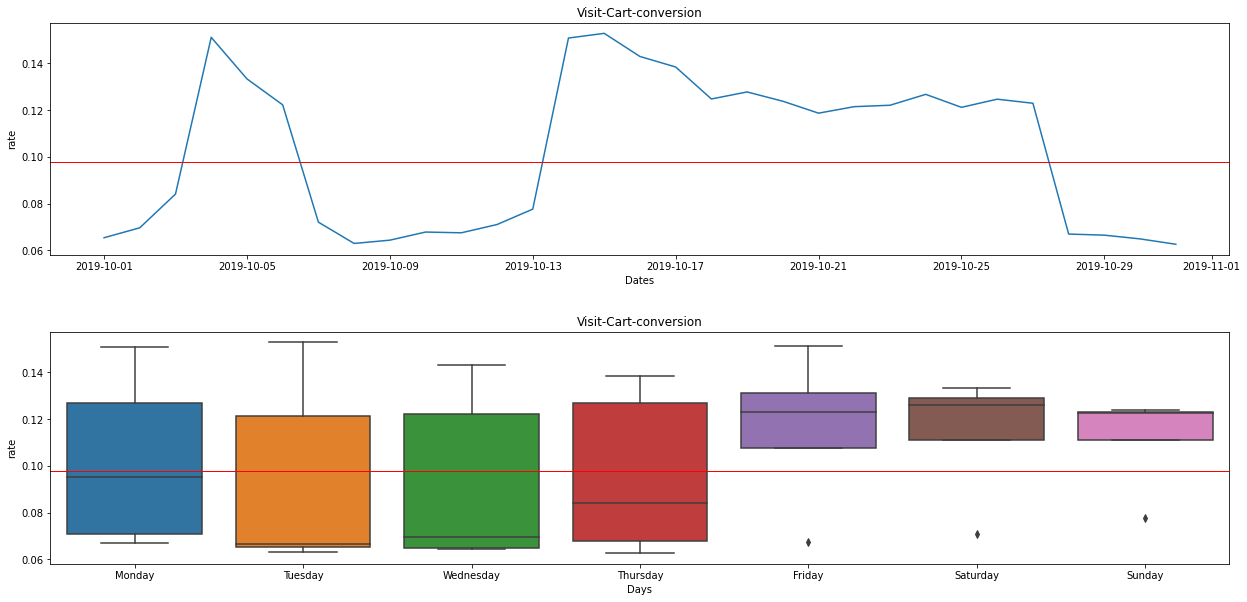

In [25]:
# 일자별 Visit-Cart Conversion

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Visit-Cart-conversion',
              data=conversion_table,
             ax=ax1)
plt.axhline(y=0.098, color='r', linewidth=1)
plt.title('Visit-Cart-conversion')
plt.ylabel('rate')
plt.xlabel('Dates')

# 요일별 Visit-Cart Conversion

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=conversion_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=conversion_table['Visit-Cart-conversion'],
            ax=ax2)
plt.axhline(y=0.098, color='r', linewidth=1)
plt.title('Visit-Cart-conversion')
plt.ylabel('rate')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

## Cart-Sale Conversion
- 방문 세션과 판매량이 가장 많은 요일임에도 금토일의 전환율이 눈에 띄게 낮음
- 반대로, 카트에 물건을 담은 횟수 대비 구매 수는 월~목이 제일 많음
- 주말은 충동 구매할 확률이 높다?

In [26]:
# Cart-Sale Conversion

print('Cart-Sale Conversion Rates Statistics')
print('-'*50)
print(conversion_table['Cart-Sale-conversion'].describe())
print('-'*50)
print('Cart-Sale Conversion Rates Statistics by Dates')
print('-'*50)
print(conversion_table.groupby(by=conversion_table['event_time'].dt.day_name())['Cart-Sale-conversion'].describe())

Cart-Sale Conversion Rates Statistics
--------------------------------------------------
count    31.000000
mean      0.849838
std       0.251979
min       0.513302
25%       0.630705
50%       0.667373
75%       1.121968
max       1.184681
Name: Cart-Sale-conversion, dtype: float64
--------------------------------------------------
Cart-Sale Conversion Rates Statistics by Dates
--------------------------------------------------
            count      mean       std       min       25%       50%       75%  \
event_time                                                                      
Friday        4.0  0.747040  0.270834  0.594297  0.613754  0.620497  0.753783   
Monday        4.0  0.878561  0.281770  0.610735  0.647363  0.890257  1.121455   
Saturday      4.0  0.754870  0.269260  0.599908  0.621236  0.630705  0.764339   
Sunday        4.0  0.759345  0.245405  0.596823  0.640423  0.657829  0.776752   
Thursday      5.0  0.899491  0.229611  0.645690  0.674570  0.946980  1.097156   


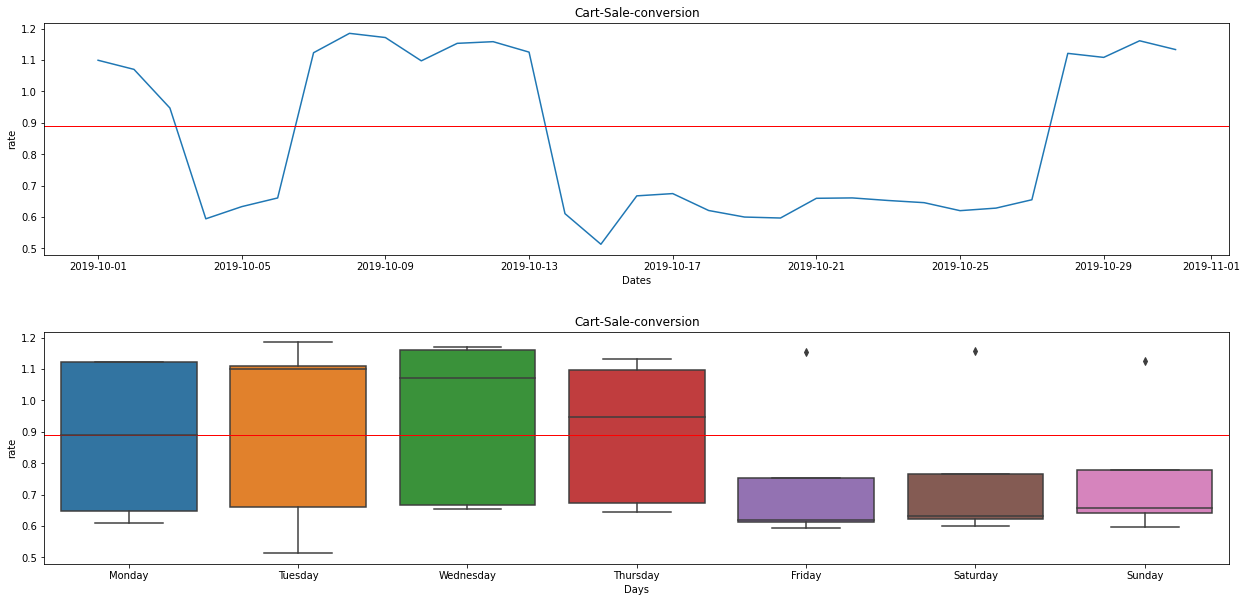

In [27]:
# Cart-Sales-Conversion
# 금-토-일은 카트에 담지 않고 바로 구매하나?
# 판매량은 금-토-일이 제일 많음
# 카트에 물건을 담은 횟수 대비 구매 수는 월~목이 제일 많음
# 카트에 물건을 담은 사람들은 주말 충동 구매를 하지 않음?

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Cart-Sale-conversion',
              data=conversion_table,
             ax=ax1)
plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Cart-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Dates')

# 요일별 판매량

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=conversion_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=conversion_table['Cart-Sale-conversion'],
            ax=ax2)
plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Cart-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

In [28]:
"""

# 요일 별로 극단치를 제거할 수 있을까?

conversion_threshold = np.percentile(conversion_table['Cart-Sale-conversion'], [1, 95])
conversion_threshold_filter = np.logical_and(conversion_table['Cart-Sale-conversion'] >= conversion_threshold[0],
                                             conversion_table['Cart-Sale-conversion'] <= conversion_threshold[1])

Cart_Sale_conversion_filtered = conversion_table.loc[conversion_threshold_filter]

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Cart-Sale-conversion',
              data=Cart_Sale_conversion_filtered,
             ax=ax1)
#plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Cart-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Dates')

# 요일별 판매량

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=Cart_Sale_conversion_filtered['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=Cart_Sale_conversion_filtered['Cart-Sale-conversion'],
            ax=ax2)
#plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Cart-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

"""

"\n\n# 요일 별로 극단치를 제거할 수 있을까?\n\nconversion_threshold = np.percentile(conversion_table['Cart-Sale-conversion'], [1, 95])\nconversion_threshold_filter = np.logical_and(conversion_table['Cart-Sale-conversion'] >= conversion_threshold[0],\n                                             conversion_table['Cart-Sale-conversion'] <= conversion_threshold[1])\n\nCart_Sale_conversion_filtered = conversion_table.loc[conversion_threshold_filter]\n\nfig=plt.figure(figsize=(18,9))\nax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프\nsns.lineplot(x='event_time',\n              y='Cart-Sale-conversion',\n              data=Cart_Sale_conversion_filtered,\n             ax=ax1)\n#plt.axhline(y=0.89, color='r', linewidth=1)\nplt.title('Cart-Sale-conversion')\nplt.ylabel('rate')\nplt.xlabel('Dates')\n\n# 요일별 판매량\n\nax2=fig.add_subplot(2,1,2)\n\nsns.boxplot(x=Cart_Sale_conversion_filtered['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 \n            y=Cart_Sale_conversion_filtered['Cart-Sale-conv

## Visit-Sale Conversion
- 월, 토, 일이 방문-구매 conversion이 비교적 높음
- 금요일은 방문수를 생각했을 때 구매율이 다소 저조한 편임
- 방문율 1위는 금요일이지만, Conversion은 평일과 비슷함
- 물건을 판매할 수 있는 기회를 놓치고 있다?
- 4\~5일과 13\~17일 경의 전환율이 다른 날보다 높음 : 해당 요일에 주로 구매하는 상품은 무엇일까?

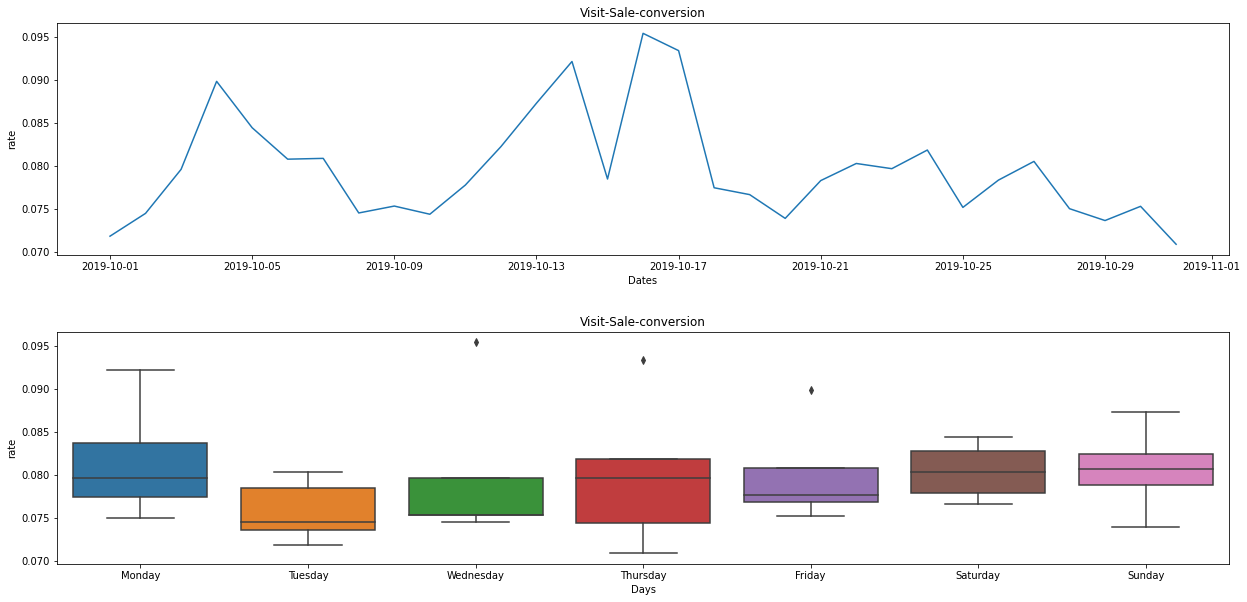

In [29]:
# 통상적인 임금일 전후로 Conversion이 높음
# 월, 토, 일이 방문-구매 conversion이 비교적 높음 
# 금요일은 방문수를 생각했을 때 구매율이 다소 저조한 편임(방문율 1위는 금 but Conversion은 평일과 비슷함)
# 물건을 판매할 수 있는 기회를 놓치고 있다?

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Visit-Sale-conversion',
              data=conversion_table,
             ax=ax1)
#plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Visit-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Dates')

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=conversion_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=conversion_table['Visit-Sale-conversion'],
            ax=ax2)
#plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Visit-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

In [30]:
conversion_table['event_time'] = conversion_table['event_time'].dt.dayofweek

In [31]:
# 금요일 이상치 제거

conversion_table_filtered = conversion_table.drop(3)
conversion_table_filtered

,event_time,Visit-Cart-conversion,Visit-Sale-conversion,Cart-Sale-conversion
0,1,0.065358,0.071829,1.099007
1,2,0.069611,0.074483,1.069994
2,3,0.084059,0.079602,0.946980
4,5,0.133396,0.084448,0.633064
5,6,0.122277,0.080789,0.660703
6,0,0.072024,0.080882,1.122993
7,1,0.062911,0.074530,1.184681
8,2,0.064314,0.075333,1.171333
9,3,0.067796,0.074382,1.097156
10,4,0.067467,0.077780,1.152869


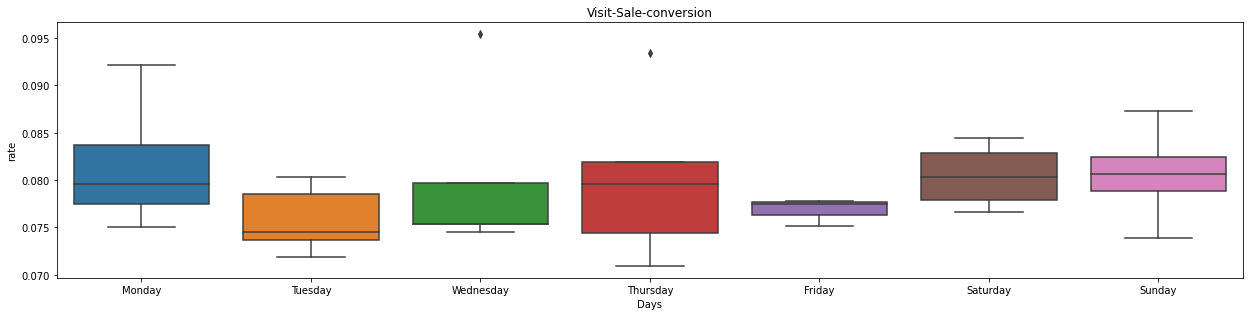

In [32]:
fig=plt.figure(figsize=(18,9))
ax2=fig.add_subplot(2,1,1)
sns.boxplot(x=conversion_table_filtered['event_time'], # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=conversion_table_filtered['Visit-Sale-conversion'],
            ax=ax2)
#plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Visit-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

## EDA - 제품별

In [33]:
# EDA 관련 함수 모음

def make_categori_df(df_full, categori):
    # 대분류 카테고리별 df 만드는 함수

    df_cate = df_full.loc[df_full['categori_code_level_1'] == categori]
    df_cate['categori_code_level_2'] = df_cate['category_code'].str.split(".", expand=True)[1]
    return df_cate

def make_product_conversion(df_temp):
    # 제품 별 Conversion 테이블 만드는 함수
    # Groupby and Pivot
    df_cate_action = df_temp.groupby(['categori_code_level_2', 'event_type']).size().to_frame().reset_index()
    df_cate_action = pd.pivot_table(df_cate_action, index = ['categori_code_level_2'], columns = ['event_type'], values = 0).reset_index()

    # Conversion 계산
    df_cate_action['total'] = df_cate_action['cart'] + df_cate_action['purchase'] + df_cate_action['view']
    df_cate_action['view_purchase_con'] = df_cate_action['purchase'] / df_cate_action['view']
    df_cate_action['view_cart_con'] = df_cate_action['cart'] / df_cate_action['view']
    df_cate_action['cart_purchase_con'] = df_cate_action['purchase'] / df_cate_action['cart']
    
    return df_cate_action

def make_visit_table(df):
    # 제품 별 방문 횟수 Counting
    elec_daily_summary_table=df.groupby(by=[df['event_time'].dt.normalize()]).agg(
    Number_of_daily_visits=('user_session', lambda x: x.nunique()),
    Number_of_daily_visitors=('user_id', lambda x: x.nunique()))

    return elec_daily_summary_table

In [34]:
# 대분류 칼럼 생성

df["categori_code_level_1"] = df["category_code"].str.split(".", expand=True)[0]
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,categori_code_level_1
0,2019-10-01 00:00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,NaN
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,appliances
2,2019-10-01 00:00:01,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,furniture
3,2019-10-01 00:00:01,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics


In [35]:
df.loc[df['categori_code_level_1'] == 'auto']

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,categori_code_level_1
189,2019-10-01 00:02:33,view,50600002,2134905044833666047,auto.accessories.compressor,NaN,89.81,514933060,2f36c9e1-b1e1-4b56-99f2-f3a7bdf0307d,auto
194,2019-10-01 00:02:40,view,50600000,2134905044833666047,auto.accessories.compressor,NaN,102.42,514933060,2f36c9e1-b1e1-4b56-99f2-f3a7bdf0307d,auto
389,2019-10-01 00:06:13,view,6000229,2053013560807654091,auto.accessories.alarm,starline,138.23,518090724,3c63ed7c-0739-4121-9363-370c3a453a34,auto
415,2019-10-01 00:06:40,view,5700619,2053013553970938175,auto.accessories.player,jvc,46.33,522487767,7e392ded-de18-4325-9228-a8f402c77906,auto
593,2019-10-01 00:09:44,view,5700518,2053013553970938175,auto.accessories.player,NaN,123.53,555448573,9da08ef8-76dc-4588-9e95-8df70e64fcfb,auto
...,...,...,...,...,...,...,...,...,...,...
42448636,2019-10-31 23:59:05,view,50600098,2134905044833666047,auto.accessories.compressor,laston,134.44,513998949,a7b196d9-afe5-4dc8-9648-d578fef55abf,auto
42448640,2019-10-31 23:59:09,view,5701038,2053013553970938175,auto.accessories.player,kenwood,128.70,566280422,05b6c62b-992f-4e8e-91f7-961bcb4719cd,auto
42448659,2019-10-31 23:59:16,view,5701331,2053013553970938175,auto.accessories.player,ams,221.37,566279704,efd58a11-6fbf-4aa2-86c1-aad172f32fac,auto
42448710,2019-10-31 23:59:37,view,50600095,2134905044833666047,auto.accessories.compressor,alteco,130.25,513998949,a7b196d9-afe5-4dc8-9648-d578fef55abf,auto


In [36]:
# 대분류 아이템의 비율 확인

rate_categori = df.categori_code_level_1.value_counts(normalize=True)
categori_list = df.categori_code_level_1.unique()

print(rate_categori)

electronics     0.557926
appliances      0.171733
computers       0.080319
apparel         0.053194
furniture       0.042979
auto            0.035031
construction    0.025260
kids            0.017986
accessories     0.008215
sport           0.006099
medicine        0.000512
country_yard    0.000487
stationery      0.000261
Name: categori_code_level_1, dtype: float64


In [37]:
categori_list[1:]

array(['appliances', 'furniture', 'computers', 'electronics', 'apparel',
       'construction', 'auto', 'kids', 'sport', 'accessories', 'medicine',
       'stationery', 'country_yard'], dtype=object)

In [38]:
df_elec = make_categori_df(df, 'electronics')
df_appli = make_categori_df(df, 'appliances')
df_com = make_categori_df(df, 'computers')
df_apparel = make_categori_df(df, 'apparel')
df_furniture = make_categori_df(df, 'furniture')
df_auto = make_categori_df(df, 'auto')

### Electronic 분석

In [40]:
# 전자제품 중 세부 카테고리의 비율

df_elec['categori_code_level_2'].value_counts(normalize=True)

smartphone    0.713333
audio         0.097573
clocks        0.081116
video         0.069821
tablet        0.019633
telephone     0.015343
camera        0.003182
Name: categori_code_level_2, dtype: float64

In [39]:
# electorinic Conversion
# 카메라는 보고(view) 카드에 담는 확률은 낮지만(0.01), 카드에 담으면 구매확률이 매우 높아짐(0.92)
# 가격은 스마트폰이 더 비싼데, 카트에 담지 않고 구매하는 비율은 더 높음 -> 브랜드 수의 차이 때문일까? -> 지배적인 브랜드가 있으면 별로 고민하지 않고 그 브랜드를 살 것
# 시계 브랜드도 압도적인 시장이 있는데 카트 비율이 높다 -> 스마트워치에 대한 필요성, 효용성에 대한 설득이 다른 전자기기에 비해 아직 덜 된 편
# 스마트워치는 주로 스마트폰의 브랜드에 맞춰 구매함 -> 애플 워치의 비율이 높음 -> 그렇다면, 고민하지 않고 바로 구매할 수 있도록 판촉해야 하지 않을까? -> 효용성에 대한 제시
# 브랜드 담당자가 아니기 때문에 브랜드 분석까지는 안해도 될 것 같음

df_elec_conv = make_product_conversion(df_elec)
df_elec_conv.sort_values('view_purchase_con')

event_type,categori_code_level_2,cart,purchase,view,total,view_purchase_con,view_cart_con,cart_purchase_con
1,camera,564,524,50220,51308,0.010434,0.011231,0.929078
2,clocks,20335,17906,1269744,1307985,0.014102,0.016015,0.880551
5,telephone,5342,3738,238317,247397,0.015685,0.022416,0.699738
4,tablet,9132,5603,301839,316574,0.018563,0.030255,0.613557
6,video,36366,21647,1067848,1125861,0.020272,0.034055,0.595254
0,audio,52678,35592,1485085,1573355,0.023966,0.035471,0.675652
3,smartphone,549743,338018,10614666,11502427,0.031844,0.051791,0.614865


In [102]:
df_elec_unique = df_elec.drop_duplicates('product_id')
df_elec_unique.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,categori_code_level_1,categori_code_level_2
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics,smartphone
9,2019-10-01 00:00:11,view,1004545,2053013555631882655,electronics.smartphone,huawei,566.01,537918940,406c46ed-90a4-4787-a43b-59a410c1a5fb,electronics,smartphone
11,2019-10-01 00:00:11,view,1005011,2053013555631882655,electronics.smartphone,samsung,900.64,530282093,50a293fb-5940-41b2-baf3-17af0e812101,electronics,smartphone
16,2019-10-01 00:00:18,view,1801995,2053013554415534427,electronics.video.tv,haier,193.03,537192226,e3151795-c355-4efa-acf6-e1fe1bebeee5,electronics,video
19,2019-10-01 00:00:19,view,1005135,2053013555631882655,electronics.smartphone,apple,1747.79,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics,smartphone


In [88]:
# 가격에 대한 기초 통계

df_elec.groupby(['categori_code_level_2', 'event_type']).price.describe().reset_index()

,categori_code_level_2,event_type,count,mean,std,min,25%,50%,75%,max
0,audio,cart,52678.0,116.456381,69.328529,1.00,38.59,159.900,161.8300,1261.04
1,audio,purchase,35592.0,116.644359,85.979590,0.88,40.88,159.800,161.8400,2406.24
2,audio,view,1485085.0,121.488538,188.103307,0.88,33.21,77.220,160.8800,2573.81
3,camera,cart,564.0,378.296418,207.686377,58.93,231.41,437.295,463.0500,2002.37
4,camera,purchase,524.0,470.344695,338.461111,25.62,257.15,437.430,553.4000,2435.28
5,camera,view,50220.0,489.392144,521.485037,25.62,154.42,386.080,536.4175,2567.05
6,clocks,cart,20335.0,317.732174,176.415873,9.46,167.29,308.620,435.7800,1878.78
7,clocks,purchase,17906.0,269.088879,210.668192,9.46,76.45,280.110,419.0200,2574.07
8,clocks,view,1269744.0,295.137378,392.120000,4.86,67.84,175.040,350.0700,2574.07
9,smartphone,cart,549743.0,428.069425,392.544999,35.75,169.48,250.660,581.0700,2110.45


In [74]:
# 판매비율 상위 5개 브랜드

df_smartphone_rate = df_elec['brand'].loc[(df_elec['categori_code_level_2'] == 'smartphone') & (df_elec['event_type'] == 'purchase')].value_counts(normalize=True).round(3).to_frame()
df_smartphone_rate.head()

,brand
samsung,0.424
apple,0.342
xiaomi,0.115
huawei,0.065
oppo,0.032


In [108]:
# 판매비율 상위 5개 브랜드의 가격에 대한 기술통계
# 가격 분포가 고를 수록 Cart에 담고 심사숙고할 가능성이 높을까?

df_elec_unique.loc[df_elec_unique['categori_code_level_2'] == 'smartphone'].groupby(['brand']).price.describe().reset_index().sort_values('mean', ascending = False).head()

,brand,count,mean,std,min,25%,50%,75%,max
0,apple,150.0,1045.835267,413.238003,360.08,746.200,1006.335,1300.455,2072.10
9,google,10.0,764.358000,180.024300,540.30,585.605,823.625,882.685,1055.11
26,oneplus,21.0,647.402381,151.139943,367.35,540.300,646.370,759.350,874.67
35,umi,2.0,617.750000,218.411143,463.31,540.530,617.750,694.970,772.19
30,samsung,155.0,534.495226,356.549834,77.14,231.135,409.020,771.935,1544.42


In [75]:
df_camera_rate = df_elec['brand'].loc[(df_elec['categori_code_level_2'] == 'camera') & (df_elec['event_type'] == 'purchase')].value_counts(normalize=True).round(3).to_frame()
df_camera_rate.head()

,brand
sony,0.328
gopro,0.240
canon,0.170
sjcam,0.069
panasonic,0.046


In [109]:
# Camera 브랜드의 평균&최고가 제품의 가격 차이는 스마트폰 보다 적다

df_elec_unique.loc[df_elec_unique['categori_code_level_2'] == 'camera'].groupby(['brand']).price.describe().reset_index().sort_values('mean', ascending = False).head()

,brand,count,mean,std,min,25%,50%,75%,max
10,panasonic,24.0,1037.674583,603.486140,218.51,680.4500,933.830,1193.9975,2470.11
2,canon,116.0,965.619483,545.797513,117.01,524.1950,887.240,1282.7925,2541.32
8,nikon,60.0,947.107167,599.052790,117.01,526.0025,802.295,1278.1475,2559.71
14,sony,62.0,886.267903,605.831585,205.41,445.8700,693.580,1203.3550,2548.30
9,olympus,6.0,858.745000,376.746770,583.97,617.8050,733.130,892.4575,1577.31


In [77]:
df_clock_rate = df_elec['brand'].loc[(df_elec['categori_code_level_2'] == 'clocks') & (df_elec['event_type'] == 'purchase')].value_counts(normalize=True).round(3).to_frame()
df_clock_rate.head()

,brand
apple,0.438
samsung,0.167
casio,0.158
xiaomi,0.068
wonlex,0.024


In [118]:
filter = df_elec_unique['categori_code_level_2']
filter_2 = df_elec_unique['brand']

df_elec_unique.loc[(filter == 'clocks') & ((filter_2 == 'apple') | (filter_2 == 'samsung'))].groupby(['brand']).price.describe().reset_index().sort_values('max', ascending = False)

,brand,count,mean,std,min,25%,50%,75%,max
0,apple,53.0,531.230566,233.653637,257.38,383.53,463.00,604.650,1181.50
1,samsung,20.0,285.271500,83.452037,150.95,249.02,301.69,356.065,411.83


In [41]:
# 생활용품은 카트에 담기보다 바로 구매하는 경우가 많음

df_appli_conv = make_product_conversion(df_appli)
df_appli_conv.sort_values('view_purchase_con', ascending=False)

event_type,categori_code_level_2,cart,purchase,view,total,view_purchase_con,view_cart_con,cart_purchase_con
1,iron,4093,3653,157493,165239,0.023195,0.025988,0.892499
2,ironing_board,354,664,34227,35245,0.019400,0.010343,1.875706
4,personal,2704,2542,144211,149457,0.017627,0.018750,0.940089
0,environment,24522,18074,1103890,1146486,0.016373,0.022214,0.737052
3,kitchen,58370,48124,3208172,3314666,0.015000,0.018194,0.824465
5,sewing_machine,2287,1939,148014,152240,0.013100,0.015451,0.847836


In [42]:
# 컴퓨터(용품)은 카트에 담기보다 바로 구매하는 경우가 많음
# view 대비 구매 비율은 다소 낮음 

df_com_conv = make_product_conversion(df_com)
df_com_conv.sort_values('view_purchase_con', ascending=False)

event_type,categori_code_level_2,cart,purchase,view,total,view_purchase_con,view_cart_con,cart_purchase_con
3,notebook,15627,15590,1104823,1136040,0.014111,0.014144,0.997632
4,peripherals,6092,5225,376658,387975,0.013872,0.016174,0.857682
0,components,2006,3514,338049,343569,0.010395,0.005934,1.751745
2,ebooks,476,294,29060,29830,0.010117,0.016380,0.617647
1,desktop,3229,3232,417463,423924,0.007742,0.007735,1.000929


In [43]:
# NaN 값이 뜨는 이유 -> 카트에 담지 않기 때문
# 의류 분야에서는 신발 판매량이 가장 높음 -> 신발 중심의 마케팅
# 다른 세분류는 크게 의미 없는 판매량임

df_apparel_conv = make_product_conversion(df_apparel)
df_apparel_conv.sort_values('view_purchase_con', ascending=False)

event_type,categori_code_level_2,cart,purchase,view,total,view_purchase_con,view_cart_con,cart_purchase_con
0,belt,NaN,21.0,2408.0,NaN,0.008721,NaN,NaN
11,sock,7.0,21.0,2613.0,2641.0,0.008037,0.002679,3.000
8,shoes,NaN,7082.0,1199017.0,NaN,0.005907,NaN,NaN
6,scarf,NaN,10.0,2513.0,NaN,0.003979,NaN,NaN
10,skirt,NaN,4.0,1025.0,NaN,0.003902,NaN,NaN
1,costume,NaN,489.0,132710.0,NaN,0.003685,NaN,NaN
9,shorts,NaN,2.0,628.0,NaN,0.003185,NaN,NaN
13,tshirt,16.0,58.0,18621.0,18695.0,0.003115,0.000859,3.625
7,shirt,NaN,38.0,13438.0,NaN,0.002828,NaN,NaN
4,jeans,NaN,140.0,56580.0,NaN,0.002474,NaN,NaN


In [44]:
# 카트에 잘 담지 않음 -> 즉흥적으로 구매? -> 즉흥 구매를 유도할만한 이벤트가 무엇이 있을까?
# 싸서 즉흥 구매하는 것일까? -> 평균 가격, 가격 분포(편차) 확인 필요

df_furniture_conv = make_product_conversion(df_furniture)
df_furniture_conv.sort_values('view_purchase_con', ascending=False)

event_type,categori_code_level_2,cart,purchase,view,total,view_purchase_con,view_cart_con,cart_purchase_con
2,kitchen,944.0,1898.0,211059.0,213901.0,0.008993,0.004473,2.010593
0,bathroom,15.0,245.0,29890.0,30150.0,0.008197,0.000502,16.333333
1,bedroom,980.0,2499.0,396991.0,400470.0,0.006295,0.002469,2.550000
3,living_room,467.0,3619.0,583597.0,587683.0,0.006201,0.000800,7.749465
4,universal,NaN,40.0,9908.0,NaN,0.004037,NaN,NaN


In [45]:
# 해당 분류는 세세분류까지 살펴봐야할 듯
# 동력 기계 관련 부품

df_auto_conv = make_product_conversion(df_auto)
df_auto_conv.sort_values('view_purchase_con', ascending=False)

event_type,categori_code_level_2,cart,purchase,view,total,view_purchase_con,view_cart_con,cart_purchase_con
0,accessories,9067,10620,992761,1012448,0.010697,0.009133,1.17128


In [46]:
elec_daily_summary_table = make_visit_table(df_elec)

In [47]:
elec_daily_summary_table.head()

,Number_of_daily_visits,Number_of_daily_visitors
event_time,,
2019-10-01,124384,93427
2019-10-02,123937,92267
2019-10-03,119737,88901
2019-10-04,144450,106484
2019-10-05,129301,95562
